## Import Libraries

In [1]:
import os
import sys
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from sklearn.utils import shuffle
import cv2
import glob as gb

import pandas as pd
import numpy as np
from tensorflow.keras import datasets,models,layers
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Data Preparation

In [2]:
X_train = []
y_train = []

train_path = '/kaggle/input/arabic-signature-data/train/train/'

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        if '_forg' in folder:
            label = 1 
        else:
            label = 0 
        
        
        files = gb.glob(os.path.join(folder_path, '*.jp*g'))
        for file in files:
            image = cv2.imread(file)
            image_resized = cv2.resize(image, (96, 96))
            X_train.append(image_resized)
            y_train.append(label)


X_train = np.array(X_train)
y_train = np.array(y_train)
print("Training data shape:", X_train.shape)
print("Labels shape:", y_train.shape)

Training data shape: (2979, 96, 96, 3)
Labels shape: (2979,)


In [3]:
X_test = []
y_test = []


test_path = '/kaggle/input/arabic-signature-data/test/test/'

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    if os.path.isdir(folder_path):
        
        if '_forg' in folder:
            label = 1 
        else:
            label = 0 
        
        
        files = gb.glob(os.path.join(folder_path, '*.jp*g'))
        for file in files:
            image = cv2.imread(file)
            image_resized = cv2.resize(image, (96, 96))
            X_test.append(image_resized)
            y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)
print("Test data shape:", X_test.shape)
print("Labels shape:", y_test.shape)

Test data shape: (492, 96, 96, 3)
Labels shape: (492,)


In [4]:
real_signature_images = [X_train[i] for i in range(len(y_train)) if y_train[i] == 0]
fake_signature_images = [X_train[i] for i in range(len(y_train)) if y_train[i] == 1]

## Visualize some Real Signature Images

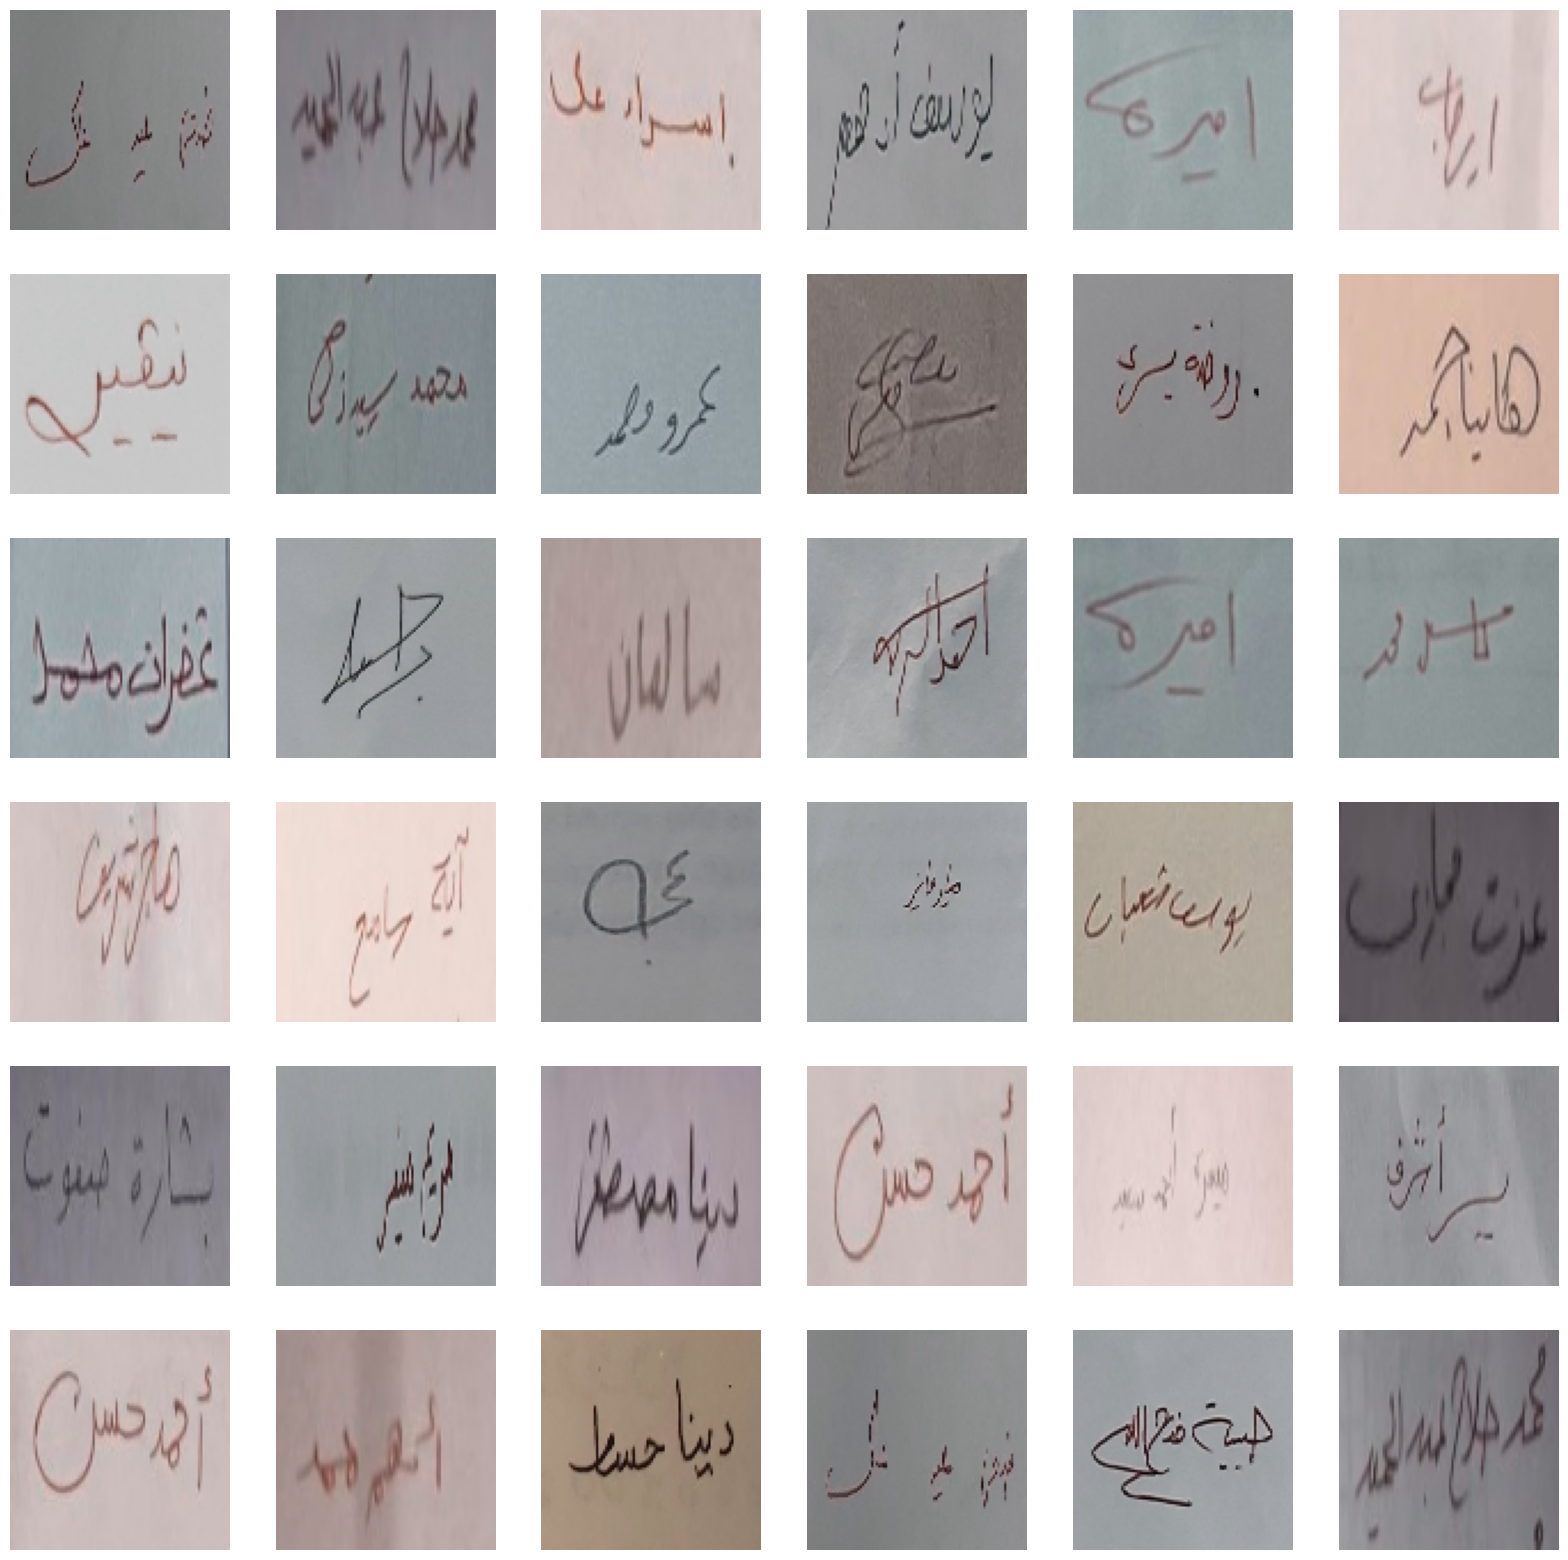

In [5]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(real_signature_images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(real_signature_images[i])   
    plt.axis('off')

## Visualize some Fake Signature Images

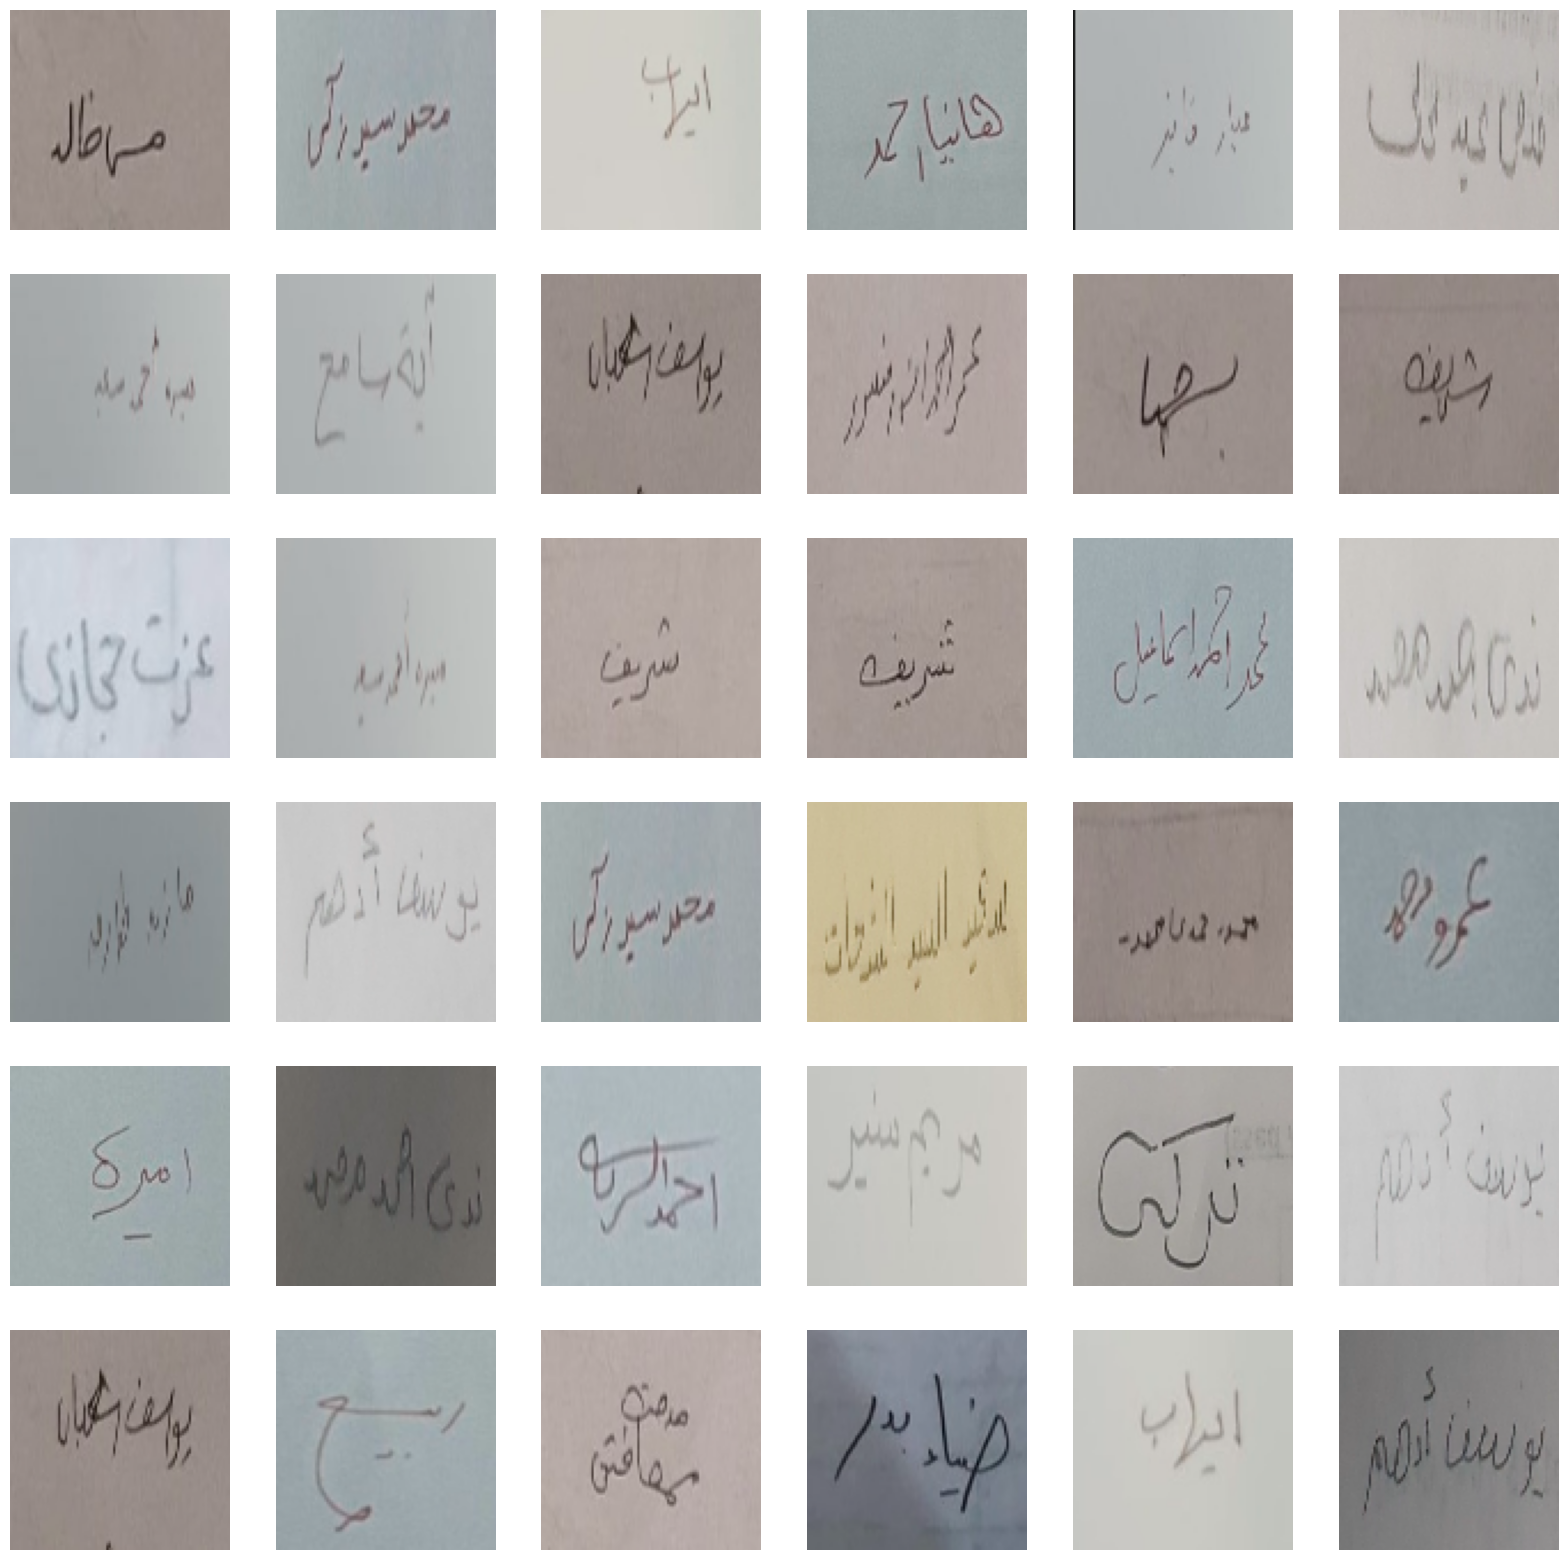

In [6]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(fake_signature_images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(fake_signature_images[i])   
    plt.axis('off')

## VGG16 Model

### Not include first dense layers..

In [7]:
model_vgg16=VGG16(weights='imagenet', input_shape=(96, 96, 3), include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model = models.Sequential()
model.add(model_vgg16)
model.add(layers.Flatten())

In [10]:
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

In [12]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.5244 - loss: 0.7195 - val_accuracy: 0.5650 - val_loss: 0.6774
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6463 - loss: 0.6169 - val_accuracy: 0.7154 - val_loss: 0.4968
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7999 - loss: 0.4347 - val_accuracy: 0.7724 - val_loss: 0.4774
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8468 - loss: 0.3637 - val_accuracy: 0.9004 - val_loss: 0.2684
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8835 - loss: 0.2864 - val_accuracy: 0.9228 - val_loss: 0.2286
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9485 - loss: 0.1403 - val_accuracy: 0.9228 - val_loss: 0.2076
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9545 - loss: 0.1170 - val_accuracy: 0.9146 - val_loss: 0.2686
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9734 - loss: 0.0706 - val_accuracy: 0

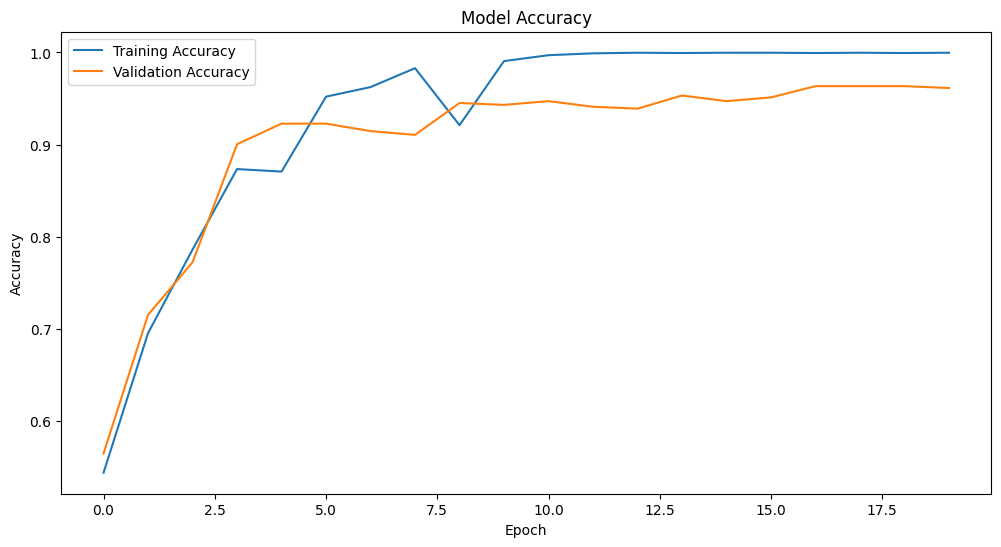

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       240
           1       0.96      0.96      0.96       252

    accuracy                           0.96       492
   macro avg       0.96      0.96      0.96       492
weighted avg       0.96      0.96      0.96       492



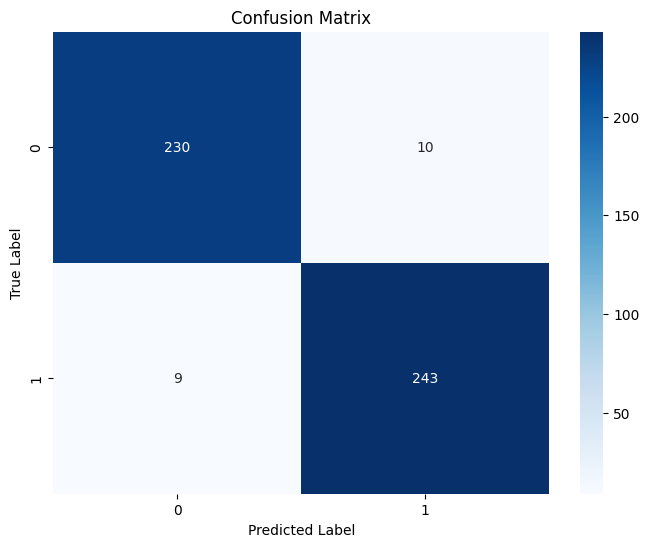

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 14.2522


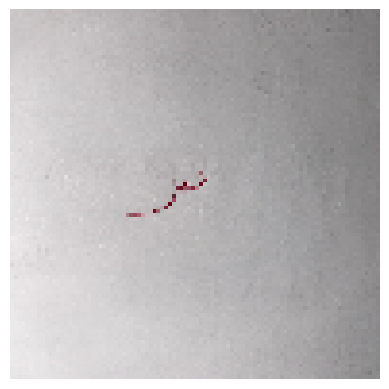

In [17]:
single_image_path = '/kaggle/input/test-sig/Original_SIG.jpg'  
img = cv2.imread(single_image_path)
img_resized = cv2.resize(img, (96, 96)) 
img_resized = img_resized / 255.0  


img_input = np.expand_dims(img_resized, axis=0)
y_single = np.array([1])

history = model.fit(img_input, y_single, epochs=1, batch_size=1, verbose=1)

plt.imshow(img_resized)
plt.axis('off') 
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


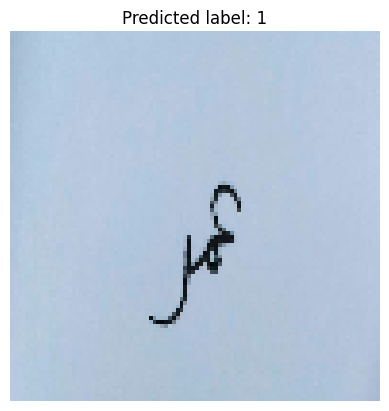

The signature is fake.


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image


single_image_path = '/kaggle/input/test-sig/Fake_SIG.jpeg'
img = cv2.imread(single_image_path)
img_resized = cv2.resize(img, (96, 96))
img_resized = img_resized / 255.0 


img_input = np.expand_dims(img_resized, axis=0)
prediction = model.predict(img_input)


predicted_label = np.argmax(prediction, axis=1)[0]


plt.imshow(img_resized)
plt.title(f"Predicted label: {predicted_label}")
plt.axis('off')
plt.show()

if predicted_label == 0:
    print("The signature is original.")
else:
    print("The signature is fake.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


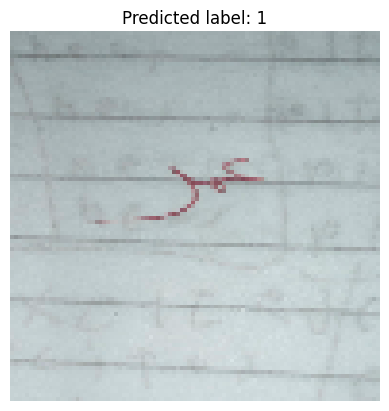

The signature is fake.


In [19]:
single_image_path = '/kaggle/input/fake-sig-2/Fake_SIG_2.jpeg'
img = cv2.imread(single_image_path)
img_resized = cv2.resize(img, (96, 96))
img_resized = img_resized / 255.0 

img_input = np.expand_dims(img_resized, axis=0)
prediction = model.predict(img_input)


predicted_label = np.argmax(prediction, axis=1)[0]


plt.imshow(img_resized)
plt.title(f"Predicted label: {predicted_label}")
plt.axis('off') 
plt.show()

if predicted_label == 0:
    print("The signature is original.")
else:
    print("The signature is fake.")